# Project 1: Writing a Data Science Blog Post

##### I chose the Boston Airbnb Dataset to understand:

**What areas are the most expensive and busy areas to stay in Boston?**
1. Are certain neighborhoods more expensive than others, and by how much?
2. Are certain neighborhoods busier at different times of the year?

**What makes a great host?** 
1. How do comments vary depending on the rating quartiles? 
2. What rating features make a super host?
3. What features correlate with higher ratings?


## Data Understanding

### Uploading Data

In [2]:
# loading libraries and set plot parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Reading our three dataframes from Kaggle - Boston Airbnb (https://www.kaggle.com/airbnb/boston#listings.csv)

df_calendar = pd.read_csv("/gdrive/My Drive/Udacity/Project_1/calendar.csv")
df_reviews = pd.read_csv("/gdrive/My Drive/Udacity/Project_1/reviews.csv")
df_listing = pd.read_csv("/gdrive/My Drive/Udacity/Project_1/listings.csv")

### Exploring Data

In [0]:
# Exploring the calendar dataframe
print(df_calendar.price.value_counts());
print(df_calendar.available.value_counts());
print(df_calendar.head());
print(df_calendar.info())

# From this dataframe it will be good to get the listing price

$150.00      20752
$65.00       17518
$75.00       16249
$100.00      15499
$200.00      14326
             ...  
$1,504.00        1
$1,695.00        1
$1,312.00        1
$1,355.00        1
$1,386.00        1
Name: price, Length: 1246, dtype: int64
f    665853
t    643037
Name: available, dtype: int64
   listing_id        date available price
0    12147973  2017-09-05         f   NaN
1    12147973  2017-09-04         f   NaN
2    12147973  2017-09-03         f   NaN
3    12147973  2017-09-02         f   NaN
4    12147973  2017-09-01         f   NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None


In [0]:
# Exploring the reviews dataframe
print(df_reviews.head())
print(df_reviews.info())
print(df_reviews.reviewer_name.value_counts())

# It will be interesting to find some comments such as clean, communication, and friendly in comments to check if they correlate with the host ratings

   listing_id  ...                                           comments
0     1178162  ...  My stay at islam's place was really cool! Good...
1     1178162  ...  Great location for both airport and city - gre...
2     1178162  ...  We really enjoyed our stay at Islams house. Fr...
3     1178162  ...  The room was nice and clean and so were the co...
4     1178162  ...  Great location. Just 5 mins walk from the Airp...

[5 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB
None
David              654
Michael            595
John 

In [0]:
# Exploring the listings dataframe
print(df_listing.head())
print(df_listing.info())

# From this dataframe I will use: id, host_response_rate, neighbourhood_cleansed, 
# room_type, price, number_of_reviews, review_scores_rating, review_scores_cleanliness,  
# review_scores_communication, review_scores_location

         id  ... reviews_per_month
0  12147973  ...               NaN
1   3075044  ...              1.30
2      6976  ...              0.47
3   1436513  ...              1.00
4   7651065  ...              2.25

[5 rows x 95 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered      

## Data Preparation

My next step will be to extract the required columns for my analysis, for each question I will use the following columns.

**Boston Area:**
* Are certain neighborhoods rated better than others? 
* Are certain neighborhoods busier at different times of the year?

**Host Ratings**
* What correlates with better ratings, a private room, full apartment, or shared room?
 * ID, listing_id, room_type, review_scores_rating
* Which features correlate with higher ratings?
 * ID, listing_id, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_communication 

In [0]:
# Making new dataframes, one for the boston area and one for the host ratings

# I'm using the boston datframe as well as the listing dataframe values
boston_df = df_calendar.merge(df_listing, left_on = 'listing_id',right_on = 'id');
boston_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308890 entries, 0 to 1308889
Data columns (total 99 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   listing_id                        1308890 non-null  int64  
 1   date                              1308890 non-null  object 
 2   available                         1308890 non-null  object 
 3   price_x                           643037 non-null   object 
 4   id                                1308890 non-null  int64  
 5   listing_url                       1308890 non-null  object 
 6   scrape_id                         1308890 non-null  int64  
 7   last_scraped                      1308890 non-null  object 
 8   name                              1308890 non-null  object 
 9   summary                           1256695 non-null  object 
 10  space                             922720 non-null   object 
 11  description                       130

In [0]:
boston_df_c = boston_df[['id','date','available','number_of_reviews','review_scores_rating','neighbourhood_cleansed','price_y']];

In [0]:
# Making the host review dataframe

hosts_df = df_listing.merge(df_reviews, left_on = 'id',right_on = 'listing_id')
hosts_df.head(2)

,id_x,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments
0,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3,3075044,13631717,2014-06-01,9645972,Dmitrii,Andrea is a great host. Neighborhood is wonder...
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84,359,2016-09-06,36,20

In [0]:
# Cleaning to just use the columns we will need in our analysis
hosts_df_c = hosts_df[['listing_id','neighbourhood_cleansed','price','experiences_offered','host_since','host_is_superhost','calculated_host_listings_count','comments','host_response_time','host_response_rate','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_communication','review_scores_location',
'review_scores_checkin','review_scores_value']]

Now that we've extracted the two dataframes for our analysis we need to clean NaN values and prepare our data for each question.

In [0]:
# Cleaning NaN values from the Boston dataframe
boston_df_c = boston_df_c.dropna(how = 'any', subset= ['review_scores_rating'])
boston_df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1011780 entries, 365 to 1308524
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   id                      1011780 non-null  int64  
 1   date                    1011780 non-null  object 
 2   available               1011780 non-null  object 
 3   number_of_reviews       1011780 non-null  int64  
 4   review_scores_rating    1011780 non-null  float64
 5   neighbourhood_cleansed  1011780 non-null  object 
 6   price_y                 1011780 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 61.8+ MB


In [0]:
# Cleaning NaN values from the Hosts dataframe
hosts_df_c = hosts_df_c.dropna(how = 'any', subset= ['price','calculated_host_listings_count','host_response_time','host_response_rate','comments','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_communication','review_scores_location','review_scores_value'])
hosts_df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67051 entries, 0 to 68274
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   listing_id                      67051 non-null  int64  
 1   neighbourhood_cleansed          67051 non-null  object 
 2   price                           67051 non-null  object 
 3   experiences_offered             67051 non-null  object 
 4   host_since                      67051 non-null  object 
 5   host_is_superhost               67051 non-null  object 
 6   calculated_host_listings_count  67051 non-null  int64  
 7   comments                        67051 non-null  object 
 8   host_response_time              67051 non-null  object 
 9   host_response_rate              67051 non-null  object 
 10  number_of_reviews               67051 non-null  int64  
 11  review_scores_rating            67051 non-null  float64
 12  review_scores_accuracy          

## Modeling

In [0]:
#Exploring the Boston dataframe
boston_df_c.info()
boston_df_c.price_y.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1011780 entries, 365 to 1308524
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   id                      1011780 non-null  int64  
 1   date                    1011780 non-null  object 
 2   available               1011780 non-null  object 
 3   number_of_reviews       1011780 non-null  int64  
 4   review_scores_rating    1011780 non-null  float64
 5   neighbourhood_cleansed  1011780 non-null  object 
 6   price_y                 1011780 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 61.8+ MB


365    $65.00
366    $65.00
367    $65.00
368    $65.00
369    $65.00
Name: price_y, dtype: object

In [0]:
# Converting price_y column to float
boston_df_c['price_y'] = boston_df_c['price_y'].replace('[\$,]','', regex=True).astype(float)
boston_df_c.price_y

365        65.0
366        65.0
367        65.0
368        65.0
369        65.0
           ... 
1308520    65.0
1308521    65.0
1308522    65.0
1308523    65.0
1308524    65.0
Name: price_y, Length: 1011780, dtype: float64

#### Are certain neighborhoods more expensive than others, and by how much?

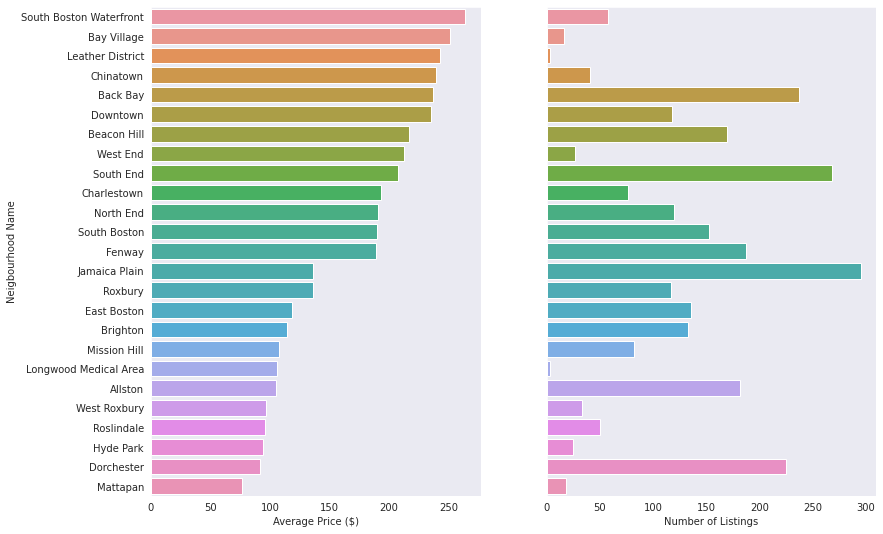

In [0]:
nb_rating = boston_df_c.groupby('neighbourhood_cleansed', as_index = False).agg({'price_y':'mean','number_of_reviews':'sum','id':pd.Series.nunique})
nb_rating = nb_rating.sort_values('price_y',ascending= False)

#Graphing the results for most expensive neighborhoods
sns.set_style("dark")

plt.figure(figsize=(13, 9))

plt.subplot(121)
sns.barplot(y = 'neighbourhood_cleansed', x = 'price_y', data = nb_rating)
plt.xlabel('Average Price ($)')
plt.ylabel('Neigbourhood Name')

plt.subplot(122)
sns.barplot(y = 'neighbourhood_cleansed', x = 'id', data = nb_rating)
plt.xlabel('Number of Listings')
plt.ylabel('')
plt.yticks([])

plt.savefig('boston_neighbourhood_price_listings.png')
plt.show()

#### Are certain neighborhoods busier at different times of the year?

In [0]:
# To answer this question, for each month, I want to get a list of the percentage of listings available by neighborhood.
boston_df_c.head()

# % Availability Calculation:
# For all listings, we take availability = t as 1 and availability = f as 0.
# Then we get the sum of T's which gives us the total days available for a listing
# and divide it by the count of 1's and 0's (total days for which the listing was posted)
# This gives us the percentage of availability for that listing

,id,date,available,number_of_reviews,review_scores_rating,neighbourhood_cleansed,price_y
365,3075044,2017-08-22,t,36,94.0,Roslindale,65.0
366,3075044,2017-08-21,t,36,94.0,Roslindale,65.0
367,3075044,2017-08-20,t,36,94.0,Roslindale,65.0
368,3075044,2017-08-19,t,36,94.0,Roslindale,65.0
369,3075044,2017-08-18,t,36,94.0,Roslindale,65.0


In [0]:
# Testing for the month of january
boston_jan = boston_df_c[(boston_df_c['date'] > '2017-01-01') & (boston_df_c['date'] < '2017-02-01')]
boston_jan = boston_jan.groupby(['neighbourhood_cleansed','id'])
boston_jan.first().sort_values('number_of_reviews', ascending = False)

date  ... price_y
neighbourhood_cleansed id                    ...        
Mission Hill           66288     2017-01-31  ...    75.0
East Boston            1497879   2017-01-31  ...    89.0
Back Bay               414419    2017-01-31  ...   175.0
Dorchester             31796     2017-01-31  ...    65.0
North End              815639    2017-01-31  ...   125.0
...                                     ...  ...     ...
Fenway                 2243499   2017-01-31  ...   285.0
                       4109165   2017-01-31  ...   219.0
                       4644069   2017-01-31  ...   110.0
                       6790961   2017-01-31  ...   319.0
West Roxbury           14767573  2017-01-31  ...    75.0

[2772 rows x 5 columns]

In [0]:
# Converting availability into 1 for true and 0 for false, so it is easier to calculate the % of listings available
boston_df_c.loc[(boston_df_c.available == 't'),'available']= 1
boston_df_c.loc[(boston_df_c.available == 'f'),'available']= 0

#Grouping by amount of unique listings, total listings available and the total count of listings with 1/0 value (to compute the availability %)
availability_per_neigh = boston_df_c.groupby('neighbourhood_cleansed', as_index = False).agg({'id':pd.Series.nunique, 'available':['sum', 'count']})

#Here, I am calculating the % available by dividing the total amount of listings available over the total amount of listings for a particular neighbourhood
availability_per_neigh['%_available'] = (availability_per_neigh['available']['sum'] /availability_per_neigh['available']['count']).multiply(100)

#Sorting from most to least available
availability_per_neigh = availability_per_neigh.sort_values('%_available', ascending = True)

Text(0, 0.5, 'Neigbourhood Name')

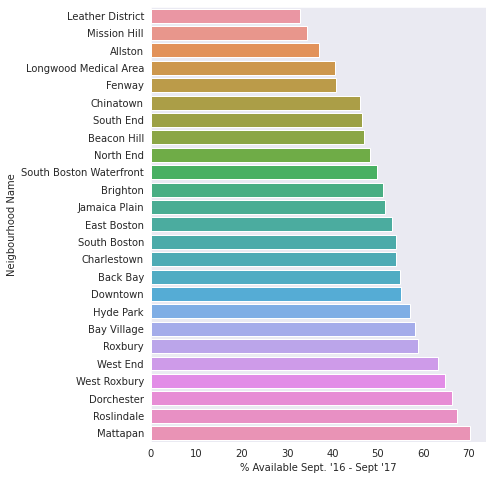

In [0]:
#Graphing the results for neighbourhood availability for the total year
fig_dims = (6, 8)
fig, ax = plt.subplots(figsize=fig_dims)
y = sns.barplot(y = 'neighbourhood_cleansed', x = '%_available',ax = ax, data = availability_per_neigh)
y.set_xlabel("% Available Sept. '16 - Sept '17")
y.set_ylabel('Neigbourhood Name')

In [0]:
# Knowing the overall availability for our timeframe, I want to find out the availability per month to notice any interesting trends
boston_df_c['date'] = pd.to_datetime(boston_df_c['date'],format='%Y-%m-%d') # transform date column to YYYY-MM-DD
boston_df_c['month'] = boston_df_c['date'].dt.month 
boston_df_c['year'] = boston_df_c['date'].dt.year 

In [0]:
# Grouping % availability by month and neighbourhood
monthly_availability_nb = boston_df_c.groupby(['month','neighbourhood_cleansed'], as_index= False).agg({'id':pd.Series.nunique, 'available':['sum', 'count']})
monthly_availability_nb['%_available'] = (monthly_availability_nb['available']['sum'] /monthly_availability_nb['available']['count']).multiply(100)
monthly_availability_nb

month   neighbourhood_cleansed      id available       %_available
                                   nunique       sum count            
0       1                  Allston     182      2513  5642   44.540943
1       1                 Back Bay     237      4914  7347   66.884443
2       1              Bay Village      16       317   496   63.911290
3       1              Beacon Hill     169      2770  5239   52.872686
4       1                 Brighton     133      2503  4123   60.708222
..    ...                      ...     ...       ...   ...         ...
295    12             South Boston     153      2904  4743   61.227071
296    12  South Boston Waterfront      58      1055  1798   58.676307
297    12                South End     268      4347  8308   52.323062
298    12                 West End      27       651   837   77.777778
299    12             West Roxbury      33       723  1023   70.674487

[300 rows x 6 columns]

Text(69.0, 0.5, 'Neighbourhood')

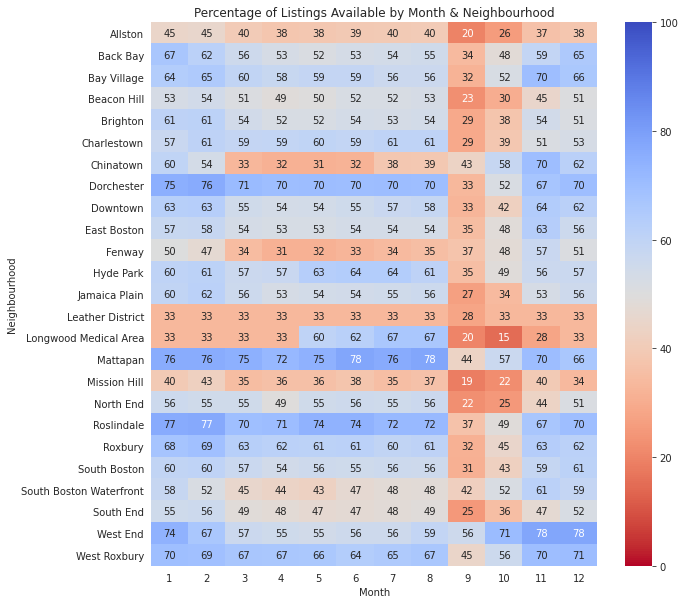

In [0]:
# Creating pivot to show the % available for each neighbourhood
monthly_heatmap_data = monthly_availability_nb.pivot(index = 'neighbourhood_cleansed', columns= 'month', values = '%_available')

# Creating heatmap across neighbourhoods
colormap = plt.cm.coolwarm_r

plt.subplots(figsize=(10,10))
ax = sns.heatmap(monthly_heatmap_data,annot=True, cmap = colormap, vmin= 0, vmax= 100, robust = True)
plt.title('Percentage of Listings Available by Month & Neighbourhood')
plt.xlabel('Month')
plt.ylabel('Neighbourhood')

### Hosts Questions

**Host Ratings**

* What type of comments are more common based on different types of ratings?
 * ID, review_scores_rating, comments
* What correlates with better ratings, a private room, full apartment, or shared room?
 * ID, listing_id, room_type, review_scores_rating
* What features correlate with higher ratings?
 * ID, listing_id, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_communication

In [0]:
hosts_df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67051 entries, 0 to 68274
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   listing_id                      67051 non-null  int64  
 1   neighbourhood_cleansed          67051 non-null  object 
 2   price                           67051 non-null  object 
 3   experiences_offered             67051 non-null  object 
 4   host_since                      67051 non-null  object 
 5   host_is_superhost               67051 non-null  object 
 6   calculated_host_listings_count  67051 non-null  int64  
 7   comments                        67051 non-null  object 
 8   host_response_time              67051 non-null  object 
 9   host_response_rate              67051 non-null  object 
 10  number_of_reviews               67051 non-null  int64  
 11  review_scores_rating            67051 non-null  float64
 12  review_scores_accuracy          

In [0]:
# Converting price_y column to float
hosts_df_c['price'] = hosts_df_c['price'].replace('[\$,]','', regex=True).astype(float)
hosts_df_c.price

0        65.0
1        65.0
2        65.0
3        65.0
4        65.0
         ... 
68270    69.0
68271    69.0
68272    69.0
68273    65.0
68274    65.0
Name: price, Length: 67051, dtype: float64

#### What makes a superhost?
Columns used: ID, listing_id, experiences_offered, host_since, host_is_superhost, neighbourhood_cleansed, review_scores (rating, accuracy, cleanliness, check-in, communication, location, value)

**Creating two functions to clean the data, create dummy variables and calculate the weight of each coefficient.**

In [0]:
def clean_data(df, response_var):
    '''
    INPUT
    df - pandas dataframe
    response_var - response variable 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no reviews
    2. Create X as all the columns that are not the reviews column
    3. Create y as the reviews column
    4. For each numeric variable in X, fill the column with the mean value of the column.
    5. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing values
    df = df.dropna(subset=[response_var], axis=0)

    # Check if the variable is categorical or numerical
    if (df[response_var].dtype == 'O') == True:
      y = pd.get_dummies(df[response_var], prefix= response_var, prefix_sep='_')
    else:
      y = df[response_var]

    #Drop respondent columns
    df = df.drop([response_var], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y    

In [0]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [0]:
# Let's see which columns can we use for our predictive model
hosts_df_c.columns

Index(['listing_id', 'neighbourhood_cleansed', 'price', 'experiences_offered',
       'host_since', 'host_is_superhost', 'calculated_host_listings_count',
       'comments', 'host_response_time', 'host_response_rate',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_checkin',
       'review_scores_value', 'quantile_ex_1', 'quantile_ex_2'],
      dtype='object')

In [0]:
#First, we will remove the columns that will obscure our results
super_host_df = hosts_df_c.drop(columns = ['experiences_offered','comments','listing_id','host_response_time','host_response_rate','host_since','neighbourhood_cleansed','quantile_ex_1','quantile_ex_2'])

#Converting host_is_superhost column to either 1 for true or 0 for false to allow for our predictions
super_host_df.loc[(super_host_df.host_is_superhost == 't'),'host_is_superhost']= 1
super_host_df.loc[(super_host_df.host_is_superhost == 'f'),'host_is_superhost']= 0
super_host_df.host_is_superhost = super_host_df.host_is_superhost.apply(pd.to_numeric) 

super_host_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67051 entries, 0 to 68274
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           67051 non-null  float64
 1   host_is_superhost               67051 non-null  int64  
 2   calculated_host_listings_count  67051 non-null  int64  
 3   number_of_reviews               67051 non-null  int64  
 4   review_scores_rating            67051 non-null  float64
 5   review_scores_accuracy          67051 non-null  float64
 6   review_scores_cleanliness       67051 non-null  float64
 7   review_scores_communication     67051 non-null  float64
 8   review_scores_location          67051 non-null  float64
 9   review_scores_checkin           67051 non-null  float64
 10  review_scores_value             67051 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 6.1 MB


In [0]:
# Creating X and y for our hosts dataframe:
X,y = clean_data(super_host_df, 'host_is_superhost')

In [0]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

mlr = LinearRegression(normalize= True)
mlr.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = mlr.predict(X_test)
y_train_preds = mlr.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [0]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.28397016164936095.  The rsquared on the test data was 0.2766416767719414.


In [0]:
print(X_train.shape[1]) #Number of columns

10


In [0]:
# Creating a table of the influencing coefficients to become a "super host"
coefs_df = pd.DataFrame()
coefs_df['coefs'] = X_train.columns
test = mlr.coef_
coefs_df['est_int'] = test[:]
coefs_df.sort_values(by = 'est_int', ascending = False)

,coefs,est_int
9,review_scores_value,0.173523
4,review_scores_accuracy,0.066239
6,review_scores_communication,0.032509
7,review_scores_location,0.028808
3,review_scores_rating,0.015726
5,review_scores_cleanliness,0.011967
2,number_of_reviews,0.000809
1,calculated_host_listings_count,0.000459
0,price,-0.000033
8,review_scores_checkin,-0.045093


#### Which features correlate with higher ratings?

In [0]:
# Let's see which columns can we use for our predictive model
hosts_df_c.columns

Index(['listing_id', 'neighbourhood_cleansed', 'price', 'experiences_offered',
       'host_since', 'host_is_superhost', 'calculated_host_listings_count',
       'comments', 'host_response_time', 'host_response_rate',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_checkin',
       'review_scores_value', 'quantile_ex_1', 'quantile_ex_2'],
      dtype='object')

In [0]:
#First, we will remove the columns that will obscure our results
hosts_df_c_model = hosts_df_c.drop(columns = ['experiences_offered','comments','listing_id','host_response_time','host_response_rate','host_since','host_is_superhost','neighbourhood_cleansed','quantile_ex_1','quantile_ex_2'])

hosts_df_c_model.head()

,price,calculated_host_listings_count,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_checkin,review_scores_value
0,65.0,1,36,94.0,10.0,9.0,10.0,9.0,10.0,9.0
1,65.0,1,36,94.0,10.0,9.0,10.0,9.0,10.0,9.0
2,65.0,1,36,94.0,10.0,9.0,10.0,9.0,10.0,9.0
3,65.0,1,36,94.0,10.0,9.0,10.0,9.0,10.0,9.0
4,65.0,1,36,94.0,10.0,9.0,10.0,9.0,10.0,9.0


In [0]:
# Creating X and y for our hosts dataframe:
X_2,y_2 = clean_data(hosts_df_c_model, 'review_scores_rating')

In [0]:
#Split into train and test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=.3, random_state=42)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train_2, y_train_2) #Fit

#Predict using your model
y_test_preds_2 = lm_model.predict(X_test_2)
y_train_preds_2 = lm_model.predict(X_train_2)

#Score using your model
test_score_2 = r2_score(y_test_2, y_test_preds_2)
train_score_2 = r2_score(y_train_2, y_train_preds_2)

In [0]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score_2, test_score_2))

The rsquared on the training data was 0.8427427220476394.  The rsquared on the test data was 0.8505942474034918.


In [0]:
print(X_train_2.shape[1]) #Number of columns

9


Text(0, 0.5, 'Influencing Factors')

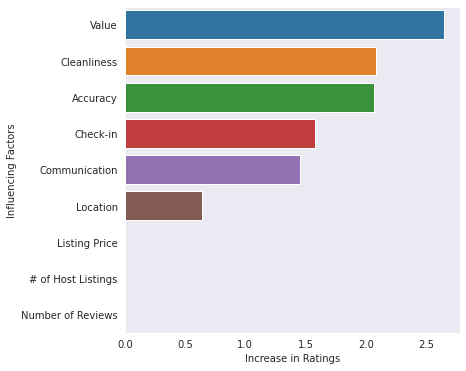

In [0]:
#Use the function
coef_df_2 = coef_weights(mlr.coef_, X_train_2)

#A quick look at the top results
coef_df_2.sort_values('coefs', ascending = False)

#Re-setting index
coef_df_2 = coef_df_2.set_index('est_int')

#Changing the index names
coef_df_2 = coef_df_2.rename(index = {'review_scores_value': 'Value', 'review_scores_cleanliness':
                          'Cleanliness','review_scores_accuracy':'Accuracy','review_scores_checkin':'Check-in'
                          , 'review_scores_communication': 'Communication', 'review_scores_location': 'Location',
                          'price':'Listing Price','calculated_host_listings_count': '# of Host Listings', 
                          'number_of_reviews':'Number of Reviews'})

#Plotting the variables versus the absolute coefficients
fig_dims = (6, 6)
fig, ax = plt.subplots(figsize=fig_dims)
y = sns.barplot(y = coef_df_2.index, x = 'abs_coefs',ax = ax, data = coef_df_2)
y.set_xlabel("Increase in Ratings")
y.set_ylabel('Influencing Factors')

From a quick look, it seems that the features that most highly correlate with better ratings are value and accuracy of the listing. While the ones that negatively impact it are whether the listing is located in Downtown or Chinatown.